<a href="https://colab.research.google.com/github/syahrinalfi/MachineLearningTasks/blob/main/15thWeekTasks/UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama : Muhammad Alfi Syahrin
* NIM : 1103213144
* Lecture : UAS
* Model : CNN (DenseNet)
* Dataset : Fashion-MNIST

In [ ]:
!pip install d2l

# **Import Library**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
from torch import nn
from d2l import torch as d2l

# **Load Dataset**

In [ ]:
# Memuat dataset Fashion-MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalisasi gambar
train_images = train_images / 255.0
test_images = test_images / 255.0

# Mengubah ukuran gambar menjadi 96x96
train_images = tf.image.resize(train_images[..., tf.newaxis], (96, 96))
test_images = tf.image.resize(test_images[..., tf.newaxis], (96, 96))

# Mengubah label menjadi one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# **Menampilkan Beberapa Contoh Gambar dari Dataset**

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

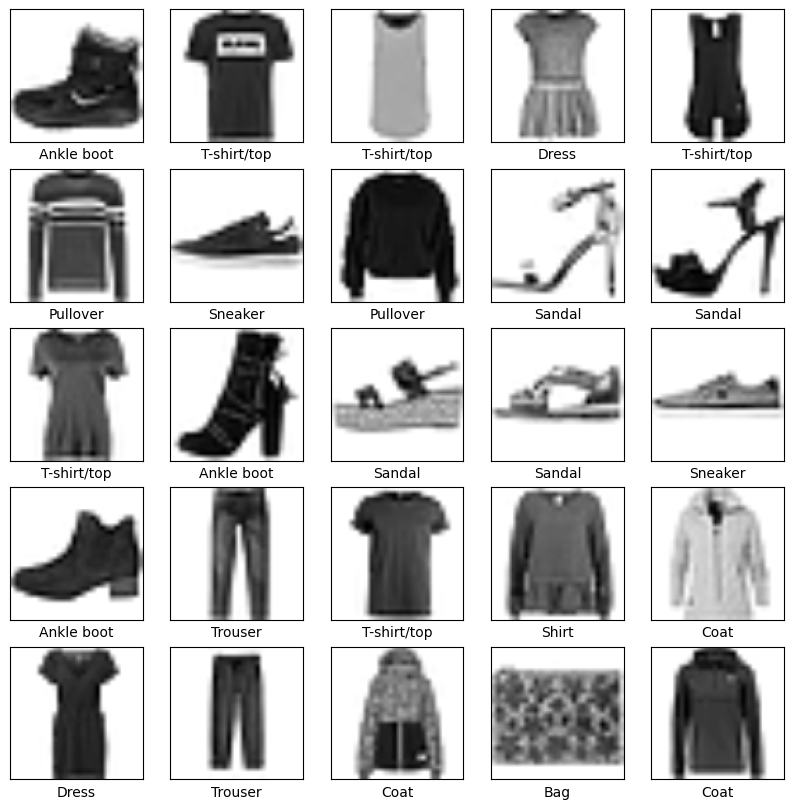

In [ ]:
# Menampilkan beberapa contoh gambar sebelum pelatihan
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.squeeze(train_images[i]), cmap=plt.cm.binary)
    plt.xlabel(class_names[tf.argmax(train_labels[i]).numpy()])
plt.show()


# **Membuat Model**

In [ ]:
# Definisi blok Dense
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(x.shape[3] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=3, name=name + '_concat')([x, x1])
    return x

def DenseNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(inputs)
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same', name='pool1')(x)

    x = dense_block(x, blocks=6, name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks=12, name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks=24, name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks=16, name='conv5')

    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(inputs, x, name='densenet')
    return model

# Inisialisasi model
input_shape = (96, 96, 1)
num_classes = 10
model = DenseNet(input_shape, num_classes)


In [ ]:
# Kompilasi model
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Melihat model yang dibuat
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 conv1/conv (Conv2D)         (None, 45, 45, 64)           3136      ['input_1[0][0]']             
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 45, 45, 64)           256       ['conv1/conv[0][0]']          
 on)                                                                                              
                                                                                                  
 conv1/relu (Activation)     (None, 45, 45, 64)           0         ['conv1/bn[0][0]']     

In [ ]:
# Melatih model
history = model.fit(train_images, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_data=(test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 202s 277ms/step - loss: 0.7504 - accuracy: 0.7422 - val_loss: 4.8489 - val_accuracy: 0.1494
Epoch 2/10
469/469 [==============================] - 118s 252ms/step - loss: 0.3699 - accuracy: 0.8638 - val_loss: 0.4673 - val_accuracy: 0.8295
Epoch 3/10
469/469 [==============================] - 134s 285ms/step - loss: 0.3004 - accuracy: 0.8895 - val_loss: 1.1911 - val_accuracy: 0.6119
Epoch 4/10
469/469 [==============================] - 128s 272ms/step - loss: 0.2645 - accuracy: 0.9029 - val_loss: 0.5210 - val_accuracy: 0.8020
Epoch 5/10
469/469 [==============================] - 120s 255ms/step - loss: 0.2488 - accuracy: 0.9092 - val_loss: 0.4486 - val_accuracy: 0.8425
Epoch 6/10
469/469 [==============================] - 121s 257ms/step - loss: 0.2300 - accuracy: 0.9154 - val_loss: 0.9164 - val_accuracy: 0.7825
Epoch 7/10
469/469 [==============================] - 120s 256ms/step - loss: 0.2115 - accuracy: 0.9240 - val_loss: 0.3861 -

## **Grafik Akurasi**

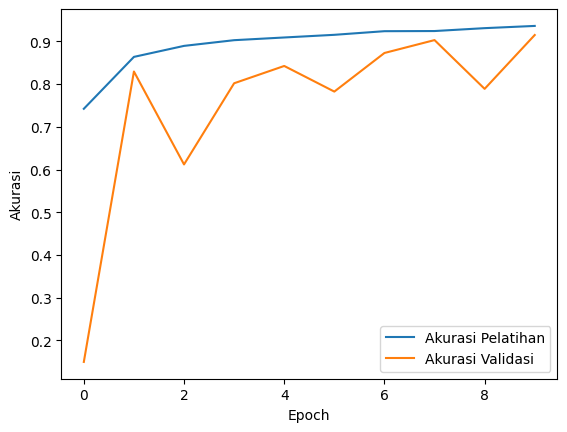

In [ ]:
# Menampilkan grafik akurasi
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.show()

# **Hasil Gambar Setelah Klasifikasi**

1/1 [==============================] - 20s 20s/step


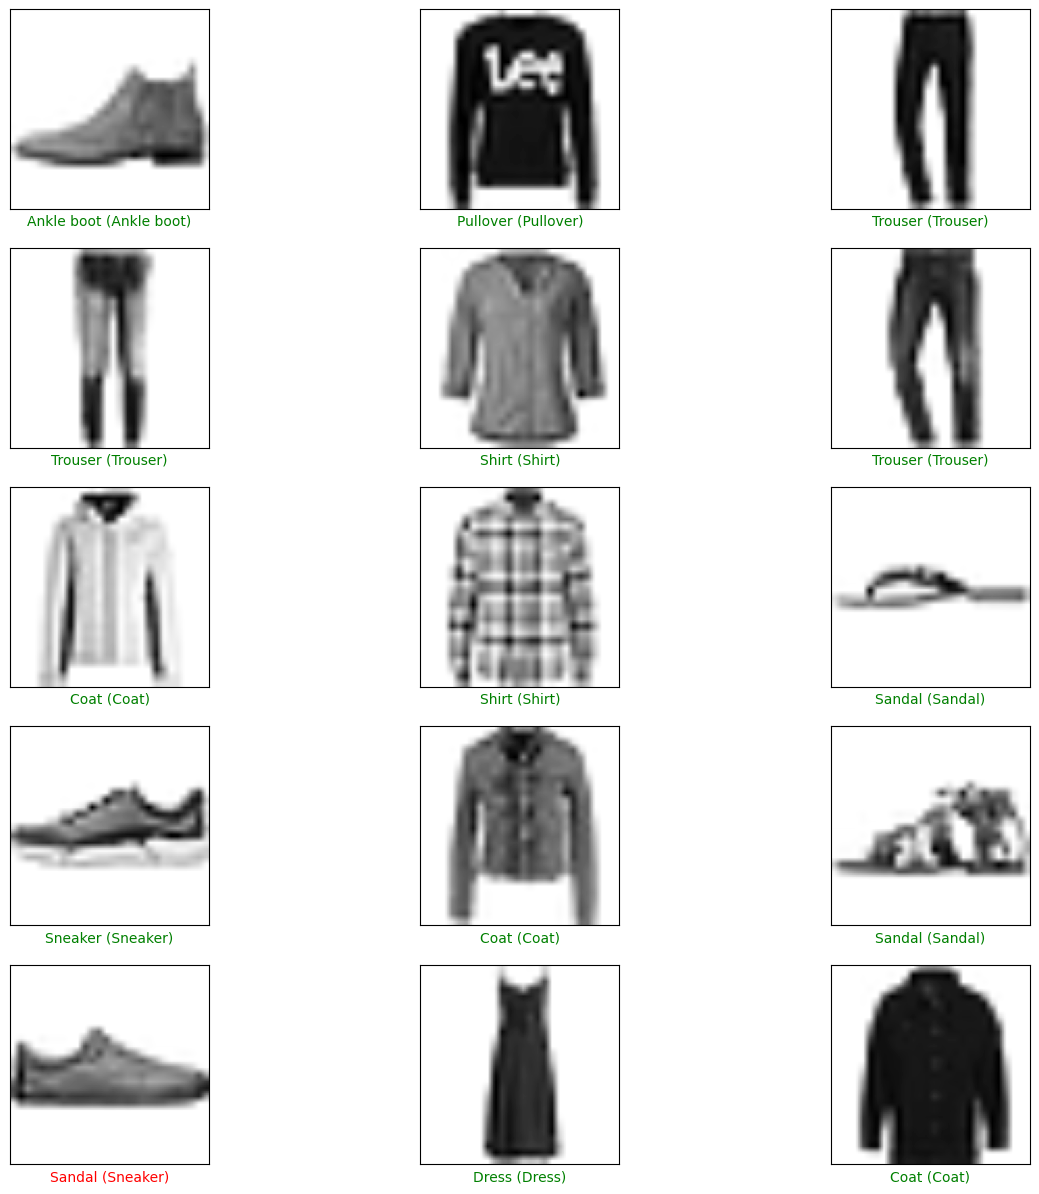

In [ ]:
# Mengambil beberapa gambar dari test set
num_images = 15
test_images_sample = test_images[:num_images]
test_labels_sample = test_labels[:num_images]

# Prediksi gambar
predictions = model.predict(test_images_sample)

# Menampilkan gambar dengan prediksi
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(5, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.squeeze(test_images_sample[i]), cmap=plt.cm.binary)
    predicted_label = class_names[predictions[i].argmax()]
    true_label = class_names[tf.argmax(test_labels_sample[i]).numpy()]
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)
plt.show()